# Tutorial 2 — Wrap an existing solver: `odeint` as a Process

In this tutorial we build an **ODE Process** that *wraps an existing numerical solver*:
`scipy.integrate.odeint`.

The point is not just “solve an ODE”, but to learn a reusable pattern:

**How to wrap an external method by exposing its API as a Process interface + config.**

We will:
1. Import and verify `odeint`
2. Define an `ODEIntProcess` that exposes the solver API (dt, params, method args)
3. Provide an ODE RHS function and configure the process
4. Run it in a `Composite`
5. Add an emitter to record trajectories

In [1]:
import numpy as np
import sys, inspect
import matplotlib.pyplot as plt

from process_bigraph import allocate_core
from process_bigraph.composite import Process, Composite

def rebuild_core():
    top = dict(inspect.getmembers(sys.modules["__main__"]))
    return allocate_core(top=top)

core = rebuild_core()
print("✅ Core ready")


✅ Core ready


In [2]:
try:
    from scipy.integrate import odeint
    print("✅ scipy.integrate.odeint imported")
except Exception as e:
    raise ImportError(
        "This tutorial requires SciPy. Install with: pip install scipy\n"
        f"Import error: {e}"
    )

✅ scipy.integrate.odeint imported


## Wrapping pattern

In this tutorial we’ll wrap an existing scientific API (`scipy.integrate.odeint`)
behind a Process-Bigraph **Process**.

We will write a Process called `ODEIntProcess` that:

- declares **ports** (`inputs()` / `outputs()`) so it can plug into a Composite
- declares a **config API** that mirrors the external library call (dt, tolerances, kwargs)
- adapts **hierarchical state** (`{"y": {"X": ...}, "t": ...}`) into solver arrays
- calls `odeint(...)` inside `update(...)`
- returns the updated state at `t + interval`
- optionally returns a small **trajectory** (`traj`) for plotting and debugging

Key design choices:

- ✅ Keep the **Process interface stable**: the same ports work across many ODE models
- Put solver details behind **config**: `dt`, `odeint_kwargs`, (and optional `return_trajectory`)
- Make the RHS easy to provide:
  - **dict-mode** RHS: `rhs(y_dict, t, params) -> dict` (most intuitive)
  - **vec-mode** RHS: `rhs(y_vec, t, params) -> array` (closest to numerical libraries)
- Use deterministic state mapping:
  - prefer explicit `state_keys`
  - otherwise fall back to `sorted(y.keys())` for reproducibility


In [3]:
import numpy as np
from scipy.integrate import odeint

class ODEIntProcess(Process):
    """
    Wrap scipy.integrate.odeint as a process-bigraph Process.

    Inputs:
      - y: map[float]   named state variables, e.g. {"X": 1.0, "Y": 0.0}
      - t: float        current time (local model time)

    Outputs:
      - y: map[float]   **delta** updates for each y variable over this interval
      - t: overwrite[float] updated time
      - traj: maybe[node] optional trajectory payload (metadata, not merged numerically)

    Config:
      - rhs: node (callable)
          Dict-mode signature: rhs(y_dict, t, params) -> dict of dy/dt
          Vec-mode signature:  rhs(y_vec,  t, params) -> array-like dy/dt
      - rhs_mode: string ("dict" or "vec"), default "dict"
      - state_keys: maybe[list[string]]
          Optional deterministic ordering of variables.
          If not provided, uses sorted(y.keys()).
      - params: node, default {}
      - dt: float, default 0.1
      - odeint_kwargs: node, default {}
      - return_trajectory: bool, default False
    """

    config_schema = {
        "rhs": "node",
        "rhs_mode": {"_type": "string", "_default": "dict"},  # "dict" or "vec"
        "state_keys": {"_type": "maybe[list[string]]", "_default": None},

        "dt": {"_type": "float", "_default": 0.1},
        "params": {"_type": "node", "_default": {}},
        "odeint_kwargs": {"_type": "node", "_default": {}},

        "return_trajectory": {"_type": "boolean", "_default": False},
    }

    def initialize(self, config=None):
        if "rhs" not in self.config or not callable(self.config["rhs"]):
            raise ValueError("ODEIntProcess requires config['rhs'] as a callable")
        mode = self.config.get("rhs_mode", "dict")
        if mode not in ("dict", "vec"):
            raise ValueError("config['rhs_mode'] must be 'dict' or 'vec'")
        return self.config

    def inputs(self):
        return {"y": "map[float]", "t": "float"}

    def outputs(self):
        # NOTE: y is delta-merged, t is overwrite (clock), traj is optional metadata
        return {"y": "map[float]", "t": "overwrite[float]", "traj": "maybe[node]"}

    # ---------- helpers ----------
    def _get_state_keys(self, y_dict):
        keys = self.config.get("state_keys")
        if keys:
            return list(keys)
        return sorted(y_dict.keys())  # deterministic fallback

    def _dict_to_vec(self, y_dict, keys):
        return np.array([float(y_dict[k]) for k in keys], dtype=float)

    def _vec_to_dict(self, y_vec, keys):
        return {k: float(y_vec[i]) for i, k in enumerate(keys)}

    def _rhs_vec(self, y_vec, t, params, keys):
        """Return dy/dt as a vector, regardless of rhs_mode."""
        rhs = self.config["rhs"]
        mode = self.config.get("rhs_mode", "dict")

        if mode == "vec":
            dy = rhs(y_vec, t, params)
            return np.asarray(dy, dtype=float)

        # dict mode
        y_dict = self._vec_to_dict(y_vec, keys)
        dy_dict = rhs(y_dict, t, params)
        if not isinstance(dy_dict, dict):
            raise ValueError("Dict-mode rhs must return a dict of derivatives")
        return np.array([float(dy_dict.get(k, 0.0)) for k in keys], dtype=float)

    # ---------- main update ----------
    def update(self, state, interval):
        y_dict = state["y"]
        t0 = float(state["t"])
        t1 = t0 + float(interval)

        keys = self._get_state_keys(y_dict)

        dt = float(self.config.get("dt", 0.1))
        params = self.config.get("params", {})
        odeint_kwargs = dict(self.config.get("odeint_kwargs", {}))
        return_traj = bool(self.config.get("return_trajectory", False))

        # Build time grid
        n_steps = max(2, int(np.ceil((t1 - t0) / dt)) + 1)
        ts = np.linspace(t0, t1, n_steps)

        y0 = self._dict_to_vec(y_dict, keys)

        def f(y_vec, t, params):
            return self._rhs_vec(y_vec, t, params, keys)

        traj = odeint(f, y0, ts, args=(params,), **odeint_kwargs)
        y_end = traj[-1, :]

        # IMPORTANT: return delta, not absolute value
        dy = y_end - y0

        out = {
            "y": self._vec_to_dict(dy, keys),  # delta update
            "t": float(t1),                    # overwrite clock
        }

        if return_traj:
            out["traj"] = {
                "t": ts.tolist(),
                "y": {k: traj[:, i].tolist() for i, k in enumerate(keys)},
                "dy": {k: float(dy[i]) for i, k in enumerate(keys)},
            }
        else:
            out["traj"] = None

        return out


print("✅ ODEIntProcess (delta-y) defined")


✅ ODEIntProcess (delta-y) defined


## Define an ODE right-hand side (RHS)

We now define a concrete ODE model and pass it into `ODEIntProcess`
*via configuration*.

This example uses **logistic growth**:

$$
\frac{dX}{dt} = r X \left(1 - \frac{X}{K}\right)
$$

Key point:
- The solver (`odeint`) is hidden inside the Process
- The *model* is injected via a small, well-defined API (`rhs`, `params`)


In [4]:
import numpy as np

def rhs_logistic(y_vec, t, params):
    """
    Logistic growth RHS.

    y_vec : numpy array, ordered according to state_keys
    t     : time (unused here, but included for generality)
    params: dict with keys 'r' and 'K'
    """
    X = float(y_vec[0])
    r = float(params["r"])
    K = float(params["K"])
    return np.array([r * X * (1.0 - X / K)], dtype=float)


# Instantiate the process directly (no Composite yet)
ode = ODEIntProcess(
    config={
        "state_keys": ["X"],
        "rhs_mode": "vec",          # <-- important for this RHS signature
        "rhs": rhs_logistic,
        "params": {"r": 1.0, "K": 10.0},
        "dt": 0.05,
        # optional: "odeint_kwargs": {"rtol": 1e-6, "atol": 1e-9},
    },
    core=core,
)

# Run a single update over a finite interval
out = ode.update(
    state={"y": {"X": 0.5}, "t": 0.0},
    interval=2.0,
)

print("Single update result:", out)


Single update result: {'y': {'X': 2.300045627983243}, 't': 2.0, 'traj': None}


## Run the ODE solver inside a Composite (with an emitter)

Now we embed `ODEIntProcess` in a `Composite` so it can be scheduled and run like
any other process-bigraph component.

We also add an **emitter** to record a time series of:
- `global_time` (the composite clock)
- `t` (the ODE's internal model time)
- `X` (the state variable)


In [5]:
from process_bigraph.emitter import emitter_from_wires

ODE_ADDR = f"local:!{ODEIntProcess.__module__}.ODEIntProcess"
print("Using address:", ODE_ADDR)

sim = Composite(
    {
        "state": {
            # shared model state
            "t": 0.0,
            "y": {"X": 0.5},

            # our ODE process node
            "ode": {
                "_type": "process",
                "address": ODE_ADDR,
                "config": {
                    "state_keys": ["X"],
                    "rhs_mode": "vec",   # <-- match rhs_logistic signature
                    "rhs": rhs_logistic,
                    "params": {"r": 1.0, "K": 10.0},
                    "dt": 0.05,
                    "odeint_kwargs": {"rtol": 1e-8, "atol": 1e-10},
                },
                "interval": 0.2,  # integrate this much each process update
                "inputs": {"t": ["t"], "y": ["y"]},
                "outputs": {"t": ["t"], "y": ["y"]},
            },

            # record a time series
            "emitter": emitter_from_wires({
                "time": ["global_time"],
                "t": ["t"],
                "X": ["y", "X"],
            }),
        }
    },
    core=core,
)

# Run the composite for 5.0 units of composite time
sim.run(10.0)

records = sim.state["emitter"]["instance"].query()
print("n records:", len(records))
print("first:", records[0])
print("last:", records[-1])


Using address: local:!__main__.ODEIntProcess
n records: 51
first: {'time': 0.0, 't': 0.0, 'X': 0.5}
last: {'time': 9.999999999999996, 't': 9.999999999999996, 'X': 9.991380977855604}


## Plot the trajectory

We can now plot `X` versus `t` using the values recorded by the emitter.


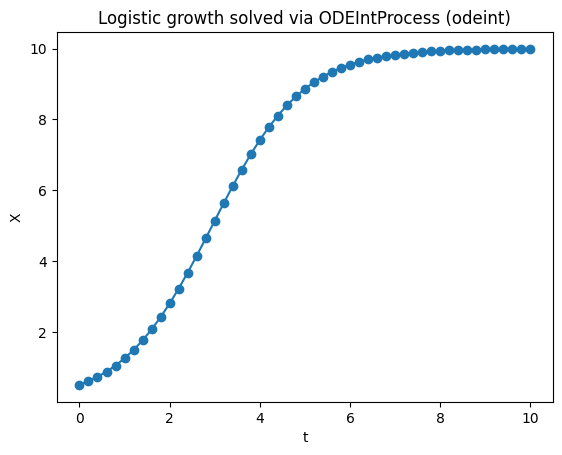

In [6]:
ts = [row["t"] for row in records]
xs = [row["X"] for row in records]

plt.figure()
plt.plot(ts, xs, marker="o")
plt.xlabel("t")
plt.ylabel("X")
plt.title("Logistic growth solved via ODEIntProcess (odeint)")
plt.show()
